In [13]:
import numpy as np
import json
from PIL import Image
import pickle
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# converts answer text to label number and vice versa
with open('/shared/eshaan/datasets/COCO/answer2label.txt') as f:
    labelandans = [json.loads(line) for line in f]
ans2label = {p['answer']: p['label'] for p in labelandans}
label2ans = {p['label']: p['answer'] for p in labelandans}

In [3]:
# converts a given qid to text question
with open('/shared/eshaan/datasets/COCO/vqa/v2_OpenEnded_mscoco_val2014_questions.json') as f:
    qid2ques = json.load(f)
qid2ques = qid2ques['questions']
qid2ques = {p['question_id']: {'question': p['question'], 'image_id': p['image_id']} for p in qid2ques}

In [4]:
# load in predictions from beit3 on a small validation set and map a prediction to a qid
with open("./vqav2_eval_stats/submit_vqav2_val.json", "r") as f:
    preds = json.load(f)
qid_preds = {p['question_id']: p['answer'] for p in preds}

In [6]:
# load in validation dataset used for predictions
with open('/shared/eshaan/datasets/COCO/vqa.rest_val.jsonl') as f:
    vqa_val = [json.loads(line) for line in f]

In [7]:
# predictions for all qids from the beit3 model
with open('./vqav2_eval_stats/logits.pkl', 'rb') as f:
    qid2logits = pickle.load(f)

In [17]:
# isolate the incorrect predictions
wrong_preds = []
for val_data in vqa_val:
    # failed
    if val_data['qid'] in qid_preds and ans2label[qid_preds[val_data['qid']]] not in val_data['labels']:
        wrong_preds.append({"qid": val_data['qid'], 
                            "image_path": val_data['image_path'], 
                            "answer": qid_preds[val_data['qid']],
                            "labels": val_data['labels'],
                            "scores": val_data['scores'],
                            "logits": qid2logits[str(val_data['qid'])]
                           })

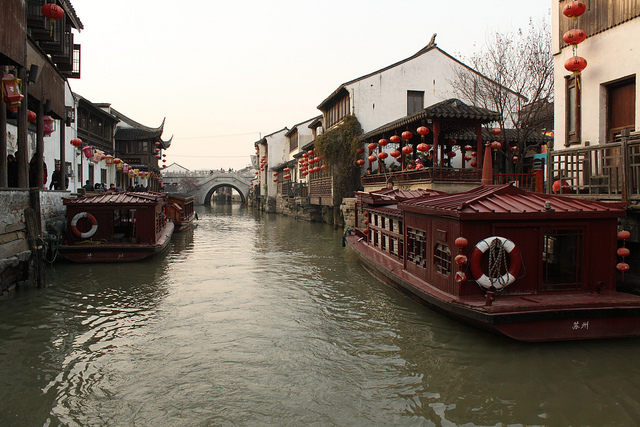

Question ID: 434192003: 
 Question: Where is the bridge? Predicted Answer: left. 
Ground Truth Answers: [('in water', 0.3), ('ahead', 0.3)]


In [18]:
# visualize the wrong predictions
for pred in wrong_preds:
    image = Image.open('/shared/eshaan/datasets/COCO/' + pred['image_path'])
    image.show()
    print(f"Question ID: {pred['qid']}: \n Question: {qid2ques[pred['qid']]['question']} Predicted Answer: {pred['answer']}. \nGround Truth Answers: {[(label2ans[pred['labels'][i]], pred['scores'][i]) for i in range(len(pred['labels']))]}")  
    break # so that it doesn't use up all the space on the instance

## K-Means Clustering!!

In [19]:
# get the logits for the wrong predictions

/home/eshaan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


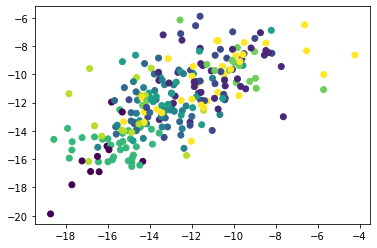

In [21]:
# generate some example data
X = np.array([pred['logits'] for pred in wrong_preds])

# initialize the k-means model with k=3 clusters
kmeans = KMeans(n_clusters=10)

# fit the model to the data
kmeans.fit(X)

# predict the cluster labels for each data point
labels = kmeans.predict(X)

# visualize the results
plt.scatter(X[:,0], X[:,1], c=labels) # admittedly it is like a bunch of dimensions
plt.show()